<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_2_%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%86%D0%B5%D0%BD%D1%8B_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D1%8B(%D0%9A%D0%BE%D0%BD%D1%8E%D1%88%D0%BE%D0%BA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRO_Вариант 2: Предсказание цены на машину
По подготовленным на занятии данным создайте обучающую, тестовую и проверочную выборки. 
По сформированным данным необходимо обучить модель для предсказания цены машины. 
Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке.

(Для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен. Это можно сделать с помощью следующего метода: predict_inverse = y_scaler.inverse_transfrom(predict).flatten() где predict - результат предсказания модели). Затем подсчитайте ошибку на каждом примере тестовой выборки и суммарный процент ошибки.

Рекомендации:

В качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse)
Метрику для данной задачи можно не использовать.
Последний слой модели должен иметь 1 нейрон.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # Отрисовка изображений
%matplotlib inline

In [3]:
cars = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Science и нейронные сети на Python/Занятие_2_Обучающая и тестовая выборки/base2/cars_new.csv")
cars.head()

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [4]:
cars.shape # размер массива

(70119, 10)

In [5]:
# Изучим состав классов
#cars.mark.describe()
#cars.model.describe()
#cars.body.describe()
#cars.kpp.describe()
cars.fuel.describe()

count      70119
unique         5
top       бензин
freq       63719
Name: fuel, dtype: object

In [6]:
cars.describe()

,price,year,mileage,volume,power
count,7.011900e+04,70119.000000,70119.000000,70119.000000,70119.000000
mean,5.277261e+05,2007.228668,162237.510988,1.917526,136.473381
std,6.236842e+05,7.086385,95872.148255,0.671154,59.054250
min,1.600000e+04,1949.000000,1.000000,0.300000,11.000000
25%,2.050000e+05,2004.000000,96980.000000,1.600000,102.000000
50%,3.800000e+05,2008.000000,147000.000000,1.800000,123.000000
75%,6.400000e+05,2012.000000,210000.000000,2.000000,152.000000
max,2.450000e+07,2019.000000,999999.000000,10.000000,1400.000000


## Подготовка данных

In [8]:
# функция создания словарей нечисловых даных
def create_dict(s):
  ret = {}                        # пуслой словарь
  for _id, name in enumerate(s):  # проходим по всем парам id и название
    ret.update({name: _id})       # добавляем в словарь
  return ret

# функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [9]:
# создаем словари по всем текстовым колонкам
# для этого подаем на функцию УНИКАЛЬНЫЕ данные в каждой колонке
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# создаем массив с ценами
prices = np.array(cars['price'], dtype=np.float)

# создаем И НОРМИРУЕМ массивы для численных колонок
from sklearn import preprocessing
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [10]:
print(fuels_dict)      #что стало
cars.fuel.describe()  # что было

{'электро': 0, 'бензин': 1, 'газ': 2, 'дизель': 3, 'гибрид': 4}


count      70119
unique         5
top       бензин
freq       63719
Name: fuel, dtype: object

In [11]:
# создаем обучающие выборки
x_arr = []
y_arr = []

# проходим по всем элементам массива данных cars
for _id, car in enumerate(np.array(cars)):
  # в y_train добавляем цену
  y_arr.append(prices[_id])

  # обьединим все колонки в один массив x_arr
  # категориальные параментры добавляем как ohe
  # числовые параметры добавляем как преобразовали
  x_tr = to_ohe(car[0],marks_dict) + to_ohe(car[1],models_dict) + \
        to_ohe(car[5],bodies_dict) + to_ohe(car[6],kpps_dict) + \
        to_ohe(car[7],fuels_dict) + [years[_id]] + [mileages[_id]] + \
        [volumes[_id]] + [powers[_id]]

  # добавляем собранный массив в x_arr
  x_arr.append(x_tr)


# превращаем list в numpy.array
print('x_arr: ', type(x_arr))
x_arr = np.array(x_arr, dtype=np.float)
y_arr = np.array(y_arr, dtype=np.float)
print('x_arr: ', type(x_arr))
print('y_arr: ', type(y_arr))

x_arr:  <class 'list'>
x_arr:  <class 'numpy.ndarray'>
y_arr:  <class 'numpy.ndarray'>


In [12]:
# размеры выборок
print(x_arr.shape)
print(y_arr.shape)

(70119, 3208)
(70119,)


In [13]:
print('x_arr [0,:20]: ', x_arr[0,:20])
print('x_arr [0,-20:]: ', x_arr[0,-20:], '\n')

x_arr [0,:20]:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
x_arr [0,-20:]:  [ 0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  1.          0.          0.          0.          1.5200145  -1.40018212
  0.12288486  0.22905575] 



In [14]:
# нормализуем y_arr
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
y_arr_scaled = y_scaler.fit_transform(y_arr.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform требует двумерный вектор
# Он не умеет работать с одним примеров

# На выходе он так же выдаёт массив примеров
# Поэтому мы делаем flatten() - уменьшение размерности

In [15]:
y_arr_scaled.shape

(70119,)

In [16]:
# выводим базовый и нормированный Y:
print('y_arr [0,:10]: ', y_arr[:10])
print('y_arr_scaled [0,:10]: ', y_arr_scaled[:10])
# обратный перевод: y_scaler.inverse_transform(y_arr_scaled)

y_arr [0,:10]:  [ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
y_arr_scaled [0,:10]:  [ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


## Выделяем тестовую выборку

In [17]:
# Выделение тестовых выборок, учитывая что мы нормировали Y - y_arr_scaled

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr_scaled, test_size = 0.2)
print ('обучающая и тестовая X: ' , len(x_train) , len(x_test))
print ('обучающая и тестовая Y: ' , len(y_train) , len(y_test))


обучающая и тестовая X:  56095 14024
обучающая и тестовая Y:  56095 14024


## Создаем нейросеть

Рекомендации:

В качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse) Метрику для данной задачи можно не использовать. Последний слой модели должен иметь 1 нейрон.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# хочу время замерить ))
from datetime import datetime

In [19]:
N_batch_size = int(3200/64) #  количество обучающих экземпляров, показанных модели перед выполнением обновления веса
N_Dence = int(3200) # Число нейронов
N_epochs = 100  # количество раз, когда модель подвергается воздействию обучающего набора данных
N_dim = 3208 # Входное пространство!!! непонятно как определять - хорошо, сообщение об ошибке подсказало
# вообще, сообщениея об ошибках реально помогают - нужно учиться их читать и разбирать!!
#N_Dropout = 0.3 - не нашел применения этому слоя
N_lr = 0.000005

In [29]:
# хочу время замерить ))
start_time = datetime.now()

# создаем нейросеть
model = Sequential()
model.add(Dense(N_Dence, input_dim=N_dim, activation='relu'))
model.add(Dense(N_Dence/4, activation='relu'))
model.add(Dense(N_Dence/16, activation='relu'))
model.add(Dense(N_Dence/64, activation='relu'))
model.add(Dense(1, activation='linear'))
# компилируем
model.compile(loss='mse', optimizer=Adam(N_lr), metrics=['accuracy'])

# задание условий установки обучения
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience=3, 
                               restore_best_weights = True)

# обучаем сеть
history = model.fit(x_train, y_train,
                    batch_size=N_batch_size, 
                    epochs=N_epochs, 
                    verbose=1, # не/ показывать процесс обучения
                    validation_split=0.3,
                    callbacks=[early_stopping])


print('Время обучения: ', datetime.now() - start_time)
print('Результаты на обучающей выборке: ', model.evaluate(x_train, y_train, verbose=0))
print('Результаты на тестовой выборке: ', model.evaluate(x_test, y_test, verbose=0))

Epoch 1/100
786/786 [==============================] - 5s 6ms/step - loss: 0.5791 - accuracy: 0.0000e+00 - val_loss: 0.2215 - val_accuracy: 0.0000e+00
Epoch 2/100
786/786 [==============================] - 5s 6ms/step - loss: 0.3161 - accuracy: 0.0000e+00 - val_loss: 0.1430 - val_accuracy: 0.0000e+00
Epoch 3/100
786/786 [==============================] - 5s 6ms/step - loss: 0.2535 - accuracy: 0.0000e+00 - val_loss: 0.1310 - val_accuracy: 0.0000e+00
Epoch 4/100
786/786 [==============================] - 5s 6ms/step - loss: 0.2206 - accuracy: 0.0000e+00 - val_loss: 0.1014 - val_accuracy: 0.0000e+00
Epoch 5/100
786/786 [==============================] - 5s 6ms/step - loss: 0.2002 - accuracy: 0.0000e+00 - val_loss: 0.0945 - val_accuracy: 0.0000e+00
Epoch 6/100
786/786 [==============================] - 5s 6ms/step - loss: 0.1844 - accuracy: 0.0000e+00 - val_loss: 0.0951 - val_accuracy: 0.0000e+00
Epoch 7/100
786/786 [==============================] - 5s 6ms/step - loss: 0.1705 - accuracy: 

In [30]:
# сохраним и загрузим веса нейронной сети для дальнейшего использования
# просто проверить, как это работает - У МНЯ НЕ ПОЛУЧИЛОСЬ (
# при закрытии ноутбука и загрузке заново, результат не тот, что был ранее

from keras.models import load_model

#model.save('cars_price_predict1.h5')
model.save_weights('cars_price_predict_weights1.hdf5')

#model__ = load_model("cars_price_predict1.h5")
model.load_weights('cars_price_predict_weights1.hdf5')

print('Результаты на обучающей выборке: ', model.evaluate(x_train, y_train, verbose=0))
print('Результаты на тестовой выборке: ', model.evaluate(x_test, y_test, verbose=0))

Результаты на обучающей выборке:  [0.08514321595430374, 0.0]
Результаты на тестовой выборке:  [0.06867099553346634, 0.0]


### Описание модели

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 3200)              10268800  
_________________________________________________________________
dense_6 (Dense)              (None, 800)               2560800   
_________________________________________________________________
dense_7 (Dense)              (None, 200)               160200    
_________________________________________________________________
dense_8 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 12,999,901
Trainable params: 12,999,901
Non-trainable params: 0
_________________________________________________________________


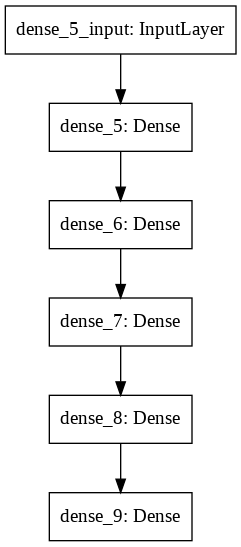

In [32]:
from keras.utils.vis_utils import plot_model

import pylab
import matplotlib.pyplot as plt
from  PIL import Image
# отрисовывать в ноутбуке
%matplotlib inline 

plot_model(model, to_file='model.png')

## Используем сеть для предсказания цены

### Сравниваю real & predict prices

In [33]:
# создаю два списка: реальные и предстказанные цены тестового массива
y_arr_test = []
y_arr_predict = []

for i in range(len(y_test)):
  x = x_test[i].reshape(1, -1)

  y = y_test[i].reshape(1, -1)
  real_price = y_scaler.inverse_transform(y).flatten()
  y_arr_test.append(real_price)

  predict_price = y_scaler.inverse_transform(model.predict(x)).flatten()
  y_arr_predict.append(predict_price)
  #print(i)
  #print(y_arr_test[i], y_arr_predict[i])

len(y_arr_predict)

14024

In [36]:
n_rec = 200
print('Автомоболь: ', x_test[n_rec].reshape(1, -1)) # не разобрался, как вывести прение характеристики авто
print('правильная цена: ', y_arr_test[n_rec])
print('Предсказание цены: ', y_arr_predict[n_rec])


Автомоболь:  [[ 0.          0.          0.         ...  1.43694987 -1.06910042
  -0.99017086]]
правильная цена:  [230000.]
Предсказание цены:  [253021.12]


Text(0.5, 0, 'y_arr_predict')

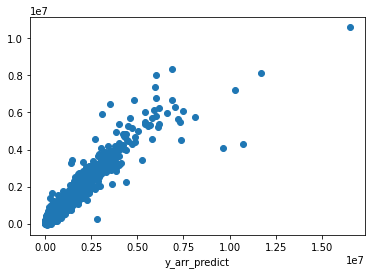

In [39]:
plt.scatter(y_arr_test, y_arr_predict)
plt.xlabel('y_arr_test')
plt.xlabel('y_arr_predict')

----
уже не хватило сил сравнить корреляции двух списов  . эх

## Выводы:


1.   Со слоем Dropout еще предстоит разобратся. Применить его с пользой в этой модели на смог
2.   Снижение BatchSize дает хороший эффект, но после какого-то времени заканчивается. Однако экспериментировать с размерами батчей нужно всегда
3.   Числом слоев Dense явно не стоит усложнять модель. Хорошо работает уменьшение числа нейронов в каждом слосе.. В моем случае я каждый следующий слой уменьшал в 4 раза, а батч сделал равным последнему слою, перед итоговым.
4.   Но самый большой эффект дало замедление скорости обучения!! Причем не Dropout, а lr при компиляции. В 200 раз !!!
5.   Хорошо работает остановка обучения модели.. Проверил от 1 до 10.. Но таки 3 - наиболее удобно с тз скорости/качества
6.  Не понятно, как определить размер Dim.. Помогло чтение сообщения об ошибке. Там было написано 3200
7.  Очевидно, что проверить качество предсказаний итоговой модели можно по-разному. я решил сделать это с помощью графиков )) не умею их строить и учусь.. 
8.  НЕ ПОЛУЧИЛОСЬ: Не смог разобраться с сохранением весов модели.. при новом открытии файла сохраненные ранее веса не работали ( 
  Также не смог вывести описание машины (моель, марка и тд и тп, цену реальную и предсказанную.. получилось только с ценами, но как вытащить во вменяемый вид описание машины - не придумал

